<a href="https://colab.research.google.com/github/santiagorestrepoo09/Android/blob/master/AlexNet_CNN__Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Define direktory
train_dir = './drive/MyDrive/DATASET/DATA-SET/train'
val_dir = './drive/MyDrive/DATASET/DATA-SET/test'

In [ ]:
# Visualize Image before Image Augmentation
train_pneumonia_img = glob(train_dir+'/PNEUMONIA/*.jpeg') # Load all pneumonia images from train directory
train_normal_img = glob(train_dir+'/NORMAL/*.jpeg') # Load all normal images frin train directory

In [ ]:
pneumonia = np.asarray(plt.imread(train_pneumonia_img[0]))
normal = np.asarray(plt.imread(train_normal_img[0]))

(672, 976)


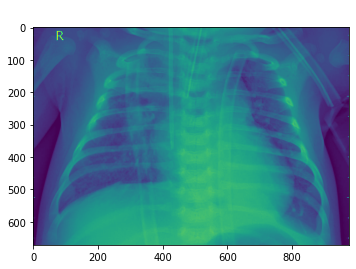

In [ ]:
plt.title('PNEUMONIA', fontsize=20, color='white')
plt.imshow(pneumonia)
print(pneumonia.shape) # print image size

(1074, 1636)


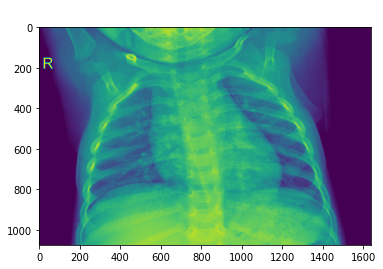

In [ ]:
plt.title('NORMAL', fontsize=20, color='white')
plt.imshow(normal)
print(normal.shape) # print image size

In [ ]:
# ImageDataGenerator for training and test
datagen = ImageDataGenerator(validation_split = 0.25, 
                             rescale=1./255, 
                             rotation_range = 30, 
                             zoom_range = 0.15, 
                             width_shift_range=0.15, 
                             height_shift_range=0.15, 
                             horizontal_flip=False,
                             vertical_flip=False)
# ImageDataGenerator for val set
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
IMG_SIZE = (227, 227)
train_set = datagen.flow_from_directory(train_dir, 
                                        subset= 'training',
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

test_set = datagen.flow_from_directory(train_dir, 
                                        subset= 'validation',
                                        class_mode='binary', 
                                        batch_size= 32,
                                        target_size=IMG_SIZE)

Found 3913 images belonging to 2 classes.
Found 1303 images belonging to 2 classes.


In [ ]:
X_train, y_train = train_set.next()
X_test, y_test = test_set.next()

In [ ]:
print('Train X=%s Y=%s' %(X_train.shape, y_train.shape))
print('Test X=%s Y=%s' %(X_test.shape, y_test.shape))

Train X=(32, 227, 227, 3) Y=(32,)
Test X=(32, 227, 227, 3) Y=(32,)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


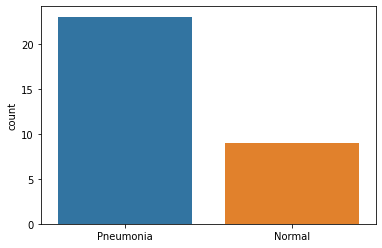

In [ ]:
labels = ['Normal' if label == 0 else 'Pneumonia' for label in y_train]
sns.countplot(labels)

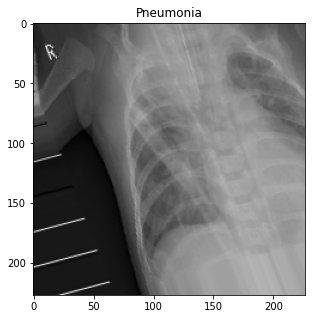

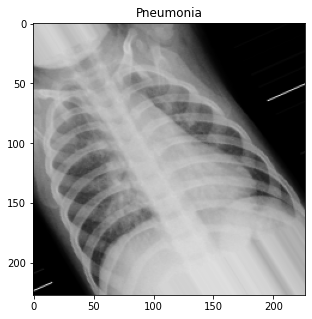

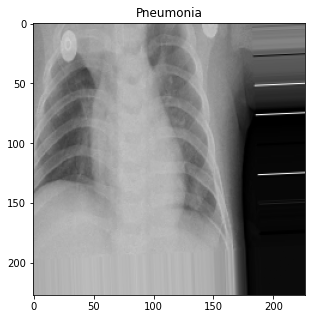

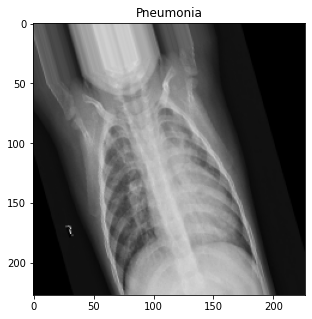

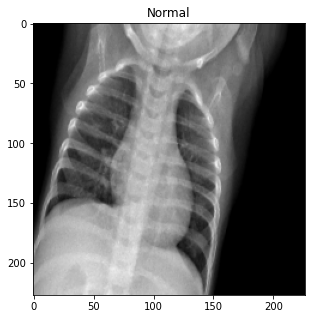

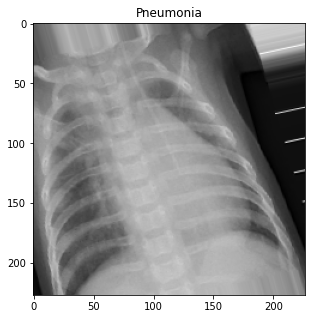

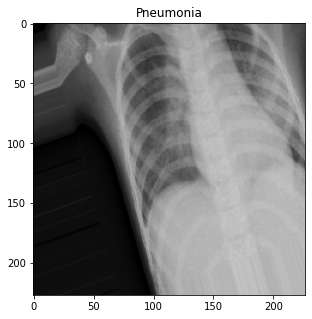

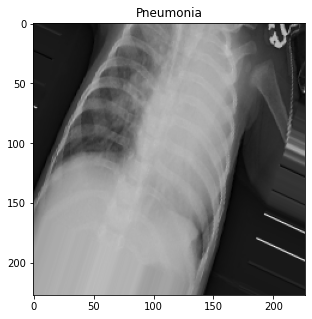

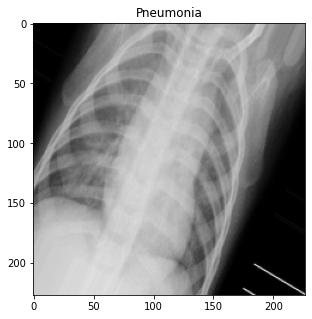

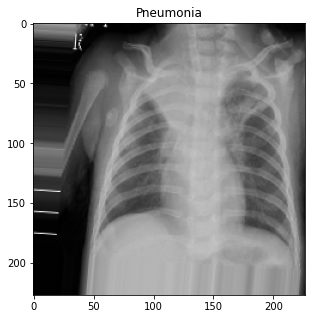

In [ ]:
for idx in range(10):
    plt.figure(figsize=(5, 5))
    plt.imshow(X_train[idx])
    plt.title(labels[idx])

In [ ]:
# Create callbacks for our model

# Create checkpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('model_alex_net.h5') 

# Create Custom callback
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.93 and logs.get('val_accuracy') > 0.93) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):
            if logs.get('accuracy') <= logs.get('val_accuracy'):
                self.model.stop_training = True
            else:
                self.model.stop_training = False
#             if(logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.94) and (logs.get('loss')<= 0.3 and logs.get('val_loss') <= 0.3):

custom_cb = CustomCallback()

In [ ]:
# Define alexNet model


model_alex_net = tf.keras.models.Sequential([
     # 1st conv layer                                        
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3),
                           padding='valid'),
    tf.keras.layers.BatchNormalization(),
    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),
    
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),

    # 2nd conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),

    # Max pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'),

    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
    # 3rd conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 4th Conv layer
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # 5th Conv layer
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    # Max Pooling
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    # # Dropout to prevent overfit
    # tf.keras.layers.Dropout(0.3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # Dropout to prevent overfit
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Look at summary of our model
model_alex_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       8

In [ ]:
model_alex_net.compile(loss='binary_crossentropy', optimizer =tf.optimizers.Adam(), metrics=['accuracy'])

In [ ]:
hist = model_alex_net.fit(
    train_set,
    validation_data = test_set,
    epochs = 32,
    callbacks=[custom_cb, checkpoint_cb]
)

Epoch 1/32
123/123 [==============================] - 1202s 10s/step - loss: 1.2775 - accuracy: 0.7674 - val_loss: 1.0340 - val_accuracy: 0.7828
Epoch 2/32
123/123 [==============================] - 781s 6s/step - loss: 0.3906 - accuracy: 0.8620 - val_loss: 1.4311 - val_accuracy: 0.7590
Epoch 3/32
123/123 [==============================] - 781s 6s/step - loss: 0.3333 - accuracy: 0.8799 - val_loss: 0.8295 - val_accuracy: 0.7928
Epoch 4/32
123/123 [==============================] - 786s 6s/step - loss: 0.2942 - accuracy: 0.8853 - val_loss: 2.5087 - val_accuracy: 0.7429
Epoch 5/32
123/123 [==============================] - 782s 6s/step - loss: 0.2876 - accuracy: 0.8922 - val_loss: 2.1748 - val_accuracy: 0.7429
Epoch 6/32
123/123 [==============================] - 779s 6s/step - loss: 0.2553 - accuracy: 0.8970 - val_loss: 1.4378 - val_accuracy: 0.7429
Epoch 7/32
123/123 [==============================] - 785s 6s/step - loss: 0.2319 - accuracy: 0.9100 - val_loss: 6.4558 - val_accuracy: 0.74

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


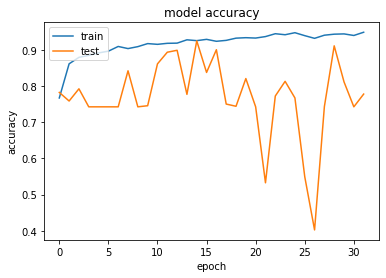

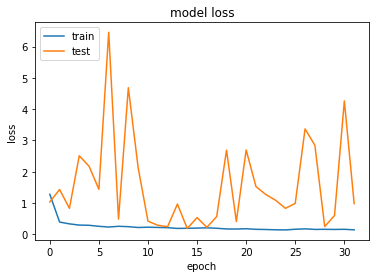

In [ ]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()